In [347]:
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers import Flatten,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D
from keras.models import Model,Sequential
from sklearn.metrics import roc_curve, auc
from keras import backend as K
from keras.datasets import mnist,fashion_mnist
import numpy as np
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils

# 1.Autoencoder

Build and fit a convolutional autoencoder for the Fashion MNIST dataset.

In [62]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [33]:
input_img = Input(shape=(28, 28, 1)) 

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)
conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
encoded = MaxPooling2D((2, 2), padding='same')(conv3)

conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
up1 = UpSampling2D((2, 2))(conv4)
conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv4)
conv5 = Conv2D(32, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv5)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 8)           0   

![image.png](https://i.loli.net/2019/12/05/FnHVcXN8s4Ai5pY.png)

In [35]:
hist = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 136s 2ms/step - loss: 0.2982 - val_loss: 0.2976
Epoch 2/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.2960 - val_loss: 0.2965
Epoch 3/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.2940 - val_loss: 0.2969
Epoch 4/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.2928 - val_loss: 0.2911
Epoch 5/10
60000/60000 [==============================] - 142s 2ms/step - loss: 0.2915 - val_loss: 0.2916
Epoch 6/10
60000/60000 [==============================] - 138s 2ms/step - loss: 0.2906 - val_loss: 0.2940
Epoch 7/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.2900 - val_loss: 0.2923
Epoch 8/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.2889 - val_loss: 0.2891
Epoch 9/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.2882 - val_loss: 0.2

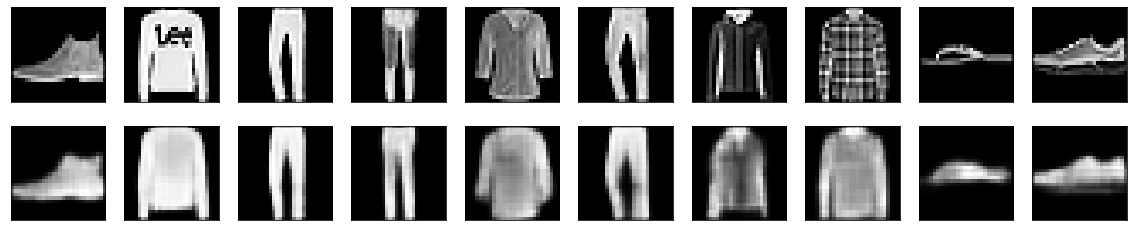

In [39]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2.Image Classification

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.

In [189]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [186]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (4,4),
                strides=(1,1),padding ='same',
                activation = 'relu',use_bias=True,
                input_shape=(28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (4,4),
                strides=(1,1),padding = 'same',
                activation = 'relu',use_bias=True))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(filters = 64, kernel_size = (2,2),
                strides=(1,1),padding = 'same',
                activation = 'relu',use_bias=True))
model.add(Conv2D(filters = 32, kernel_size = (2,2),
                strides=(1,1),padding = 'same',
                activation = 'relu',use_bias=True))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))


model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 32)        32800     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        8256      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1568)            

In [187]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [190]:
hist_DNN = model.fit(x_train,y_train, 
          batch_size = 1024,
          epochs = 10,
          verbose = 1, 
          shuffle=True,
          validation_split = 0.25,
          callbacks=[TensorBoard(log_dir='/tmp/DNN')])

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 175s 4ms/step - loss: 1.1327 - accuracy: 0.5798 - val_loss: 0.6526 - val_accuracy: 0.7549
Epoch 2/10
45000/45000 [==============================] - 170s 4ms/step - loss: 0.5719 - accuracy: 0.7860 - val_loss: 0.5241 - val_accuracy: 0.8076
Epoch 3/10
45000/45000 [==============================] - 169s 4ms/step - loss: 0.4636 - accuracy: 0.8323 - val_loss: 0.4368 - val_accuracy: 0.8432
Epoch 4/10
45000/45000 [==============================] - 165s 4ms/step - loss: 0.4013 - accuracy: 0.8577 - val_loss: 0.4084 - val_accuracy: 0.8555
Epoch 5/10
45000/45000 [==============================] - 161s 4ms/step - loss: 0.3707 - accuracy: 0.8674 - val_loss: 0.3799 - val_accuracy: 0.8633
Epoch 6/10
45000/45000 [==============================] - 161s 4ms/step - loss: 0.3458 - accuracy: 0.8764 - val_loss: 0.3468 - val_accuracy: 0.8741
Epoch 7/10
45000/45000 [==============================] - 161s

In [74]:
final = model.evaluate(x_test, y_test)
print('Loss:', final[0])
print('Accuracy:', final[1])

10000/10000 [==============================] - 7s 730us/step
Loss: 0.3032778321504593
Accuracy: 0.8896999955177307


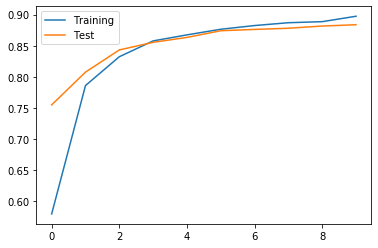

In [192]:
plt.plot(hist_DNN.history["accuracy"], label="Training")
plt.plot(hist_DNN.history["val_accuracy"], label="Test")
plt.legend()
plt.show()

## 2.2 Transfer learning

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet,VGG, etc). Report on your model’s performance on training set and test set.

In [75]:
from keras.applications.vgg16 import VGG16

In [139]:
vgg16 = VGG16(include_top = False,weights = 'imagenet',input_shape = (32,32,3))
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

make the shape of input from (*:,28,28) to (*:,32,32,3) through expanding and padding 

In [397]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [398]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [399]:
x_train = np.expand_dims(x_train,axis = 3)
x_test = np.expand_dims(x_test,axis = 3)
#x_train = np.stack((x_train,)*3,axis=-1)
#x_test = np.stack((x_test,)*3,axis = -1)
x_train.shape,x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [400]:
padded_x_train = np.pad(x_train,((0,0),(2,2),(2,2),(1,1)),'edge')
padded_x_test = np.pad(x_test,((0,0),(2,2),(2,2),(1,1)),'edge')
padded_x_train.shape,padded_x_test.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

verify we expanded the picture correctly

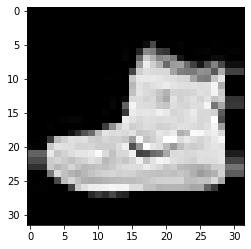

In [401]:
plt.imshow(padded_x_train[0])

In [402]:
model_vgg = Sequential()
model_vgg.add(vgg16)
model_vgg.add(Flatten())
model_vgg.add(Dense(64,activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(10,activation='softmax'))

model_vgg.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [403]:
vgg16.trainable = False

In [404]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [405]:
hist = model_vgg.fit(padded_x_train,y_train, 
          batch_size = 256,
          epochs = 10,
          verbose = 1, 
          shuffle=True,
          validation_data=(padded_x_test, y_test),
          callbacks=[TensorBoard(log_dir='/tmp/vgg')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 641s 11ms/step - loss: 3.1290 - accuracy: 0.2679 - val_loss: 1.6785 - val_accuracy: 0.4592
Epoch 2/10
60000/60000 [==============================] - 631s 11ms/step - loss: 1.6640 - accuracy: 0.4140 - val_loss: 1.4447 - val_accuracy: 0.5125
Epoch 3/10
60000/60000 [==============================] - 628s 10ms/step - loss: 1.5028 - accuracy: 0.4581 - val_loss: 1.3245 - val_accuracy: 0.5491
Epoch 4/10
60000/60000 [==============================] - 634s 11ms/step - loss: 1.3969 - accuracy: 0.4949 - val_loss: 1.2242 - val_accuracy: 0.5778
Epoch 5/10
60000/60000 [==============================] - 636s 11ms/step - loss: 1.3259 - accuracy: 0.5175 - val_loss: 1.1675 - val_accuracy: 0.5993
Epoch 6/10
60000/60000 [==============================] - 634s 11ms/step - loss: 1.2720 - accuracy: 0.5403 - val_loss: 1.1195 - val_accuracy: 0.6266
Epoch 7/10
60000/60000 [==============================] 

This model is very complicated, the model construction is as follows.

![png.png](https://i.loli.net/2019/12/05/purULTKh9ROA6o8.png)

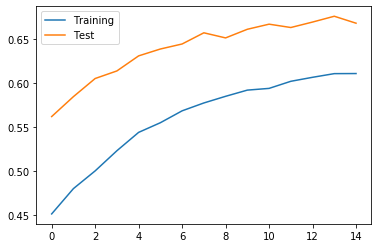

In [176]:
plt.plot(hist.history["accuracy"], label="Training")
plt.plot(hist.history["val_accuracy"], label="Test")
plt.legend()
plt.show()

# 3.Text Classification

## 3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [349]:
import pandas as pd
filename = 'tweets_with_labels.csv'
df = pd.read_csv(filename,sep='\t')
df.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77946 entries, 0 to 77945
Data columns (total 17 columns):
id       77946 non-null int64
tweet    77946 non-null object
k1       77946 non-null float64
k2       77946 non-null float64
k3       77946 non-null float64
k4       77946 non-null float64
k5       77946 non-null float64
k6       77946 non-null float64
k7       77946 non-null float64
k8       77946 non-null float64
k9       77946 non-null float64
k10      77946 non-null float64
k11      77946 non-null float64
k12      77946 non-null float64
k13      77946 non-null float64
k14      77946 non-null float64
k15      77946 non-null float64
dtypes: float64(15), int64(1), object(1)
memory usage: 10.1+ MB


In [351]:
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import nltk

first clean the text

In [352]:
def clean_text(tweets):
    #to lower case
    tweets = tweets.apply(
        lambda x: " ".join(x.lower() for x in x.split()))
    #remove stopwords
    stop = stopwords.words('english')
    tweets = tweets.apply(
        lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #remove words start with '{' ,'@','#'
    clean_tweets=[]
    for tweet in tweets:
        tokens = nltk.casual_tokenize(tweet)
        tokens =[term for term in tokens if not term.startswith('{') ]
        tokens = [term for term in tokens if not term.startswith('@')]
        punctuation = list(string.punctuation)
        tokens = [term for term in tokens if term not in punctuation]
        tokens = [term for term in tokens if not term.startswith('#')]
        sentence = ' '.join(tokens)
        clean_tweets.append(sentence)
    
    return clean_tweets

In [353]:
tweets = df['tweet']
labels = np.array(df.iloc[:,2:].values)

In [354]:
clean_tweets = np.array(clean_text(tweets))
clean_tweets.shape,labels.shape

((77946,), (77946, 15))

In [355]:
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(clean_tweets)
text_sequences = tokenizer.texts_to_sequences(clean_tweets)
tokens = pad_sequences(text_sequences,maxlen=60)
x_train,x_test,y_train,y_test = train_test_split(
    tokens,labels,test_size=0.25,random_state=6)

In [356]:
x_train.shape,y_train.shape

((58459, 60), (58459, 15))

In [357]:
model_lstm = Sequential()
model_lstm.add(Embedding(1000,64))
model_lstm.add(LSTM(64,input_shape = (33,1)))
model_lstm.add(Dropout(0.25))
model_lstm.add(Dense(15, activation = 'sigmoid'))
model_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 15)                975       
Total params: 97,999
Trainable params: 97,999
Non-trainable params: 0
_________________________________________________________________


In [358]:
model_lstm.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [359]:
lstm_history = model_lstm.fit(
    x_train,y_train,
    epochs = 3,
    validation_data = (x_test, y_test), 
    batch_size = 64,
    verbose=1,
    callbacks=[TensorBoard(log_dir='/tmp/LSTM')])

Train on 58459 samples, validate on 19487 samples
Epoch 1/3
58459/58459 [==============================] - 125s 2ms/step - loss: 0.1657 - accuracy: 0.8941 - val_loss: 0.1139 - val_accuracy: 0.9113
Epoch 2/3
58459/58459 [==============================] - 112s 2ms/step - loss: 0.1148 - accuracy: 0.9097 - val_loss: 0.1050 - val_accuracy: 0.9129
Epoch 3/3
58459/58459 [==============================] - 112s 2ms/step - loss: 0.1087 - accuracy: 0.9109 - val_loss: 0.1030 - val_accuracy: 0.9133


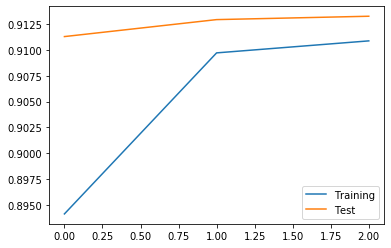

In [360]:
plt.plot(lstm_history.history["accuracy"], label="Training")
plt.plot(lstm_history.history["val_accuracy"], label="Test")
plt.legend()
plt.show()

# 3.2 CNN
Build and train a 1D CNN for this text classification task. 

In [373]:
import pandas as pd
filename = 'tweets_with_labels.csv'
df_cnn = pd.read_csv(filename,sep='\t')
df_cnn.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [374]:
tweets = df_cnn['tweet']
labels = np.array(df_cnn.iloc[:,2:].values)

In [375]:
clean_tweets = np.array(clean_text(tweets))
clean_tweets.shape,labels.shape

((77946,), (77946, 15))

In [376]:
clean_tweets = [list(x) for x in clean_tweets]

In [377]:
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(clean_tweets)
text_sequences = tokenizer.texts_to_sequences(clean_tweets)
tokens = pad_sequences(text_sequences,maxlen=140)
x_train_cnn,x_test_cnn,y_train_cnn,y_test_cnn = train_test_split(
    tokens,labels,test_size=0.25,random_state=6)
#y_train_cnn = np.expand_dims(y_train_cnn,2)
#y_test_cnn = np.expand_dims(y_test_cnn,2)
x_train_cnn.shape,y_train_cnn.shape

((58459, 140), (58459, 15))

In [378]:
model_cnn = Sequential()
model_cnn.add(Embedding(100,64))
model_cnn.add(Conv1D(10,kernel_size = 10,input_shape = (140,1)))
model_cnn.add(Conv1D(16,kernel_size = 7))
model_cnn.add(Dense(32,activation = 'relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(15, activation = 'sigmoid'))
model_cnn.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 64)          6400      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 10)          6410      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          1136      
_________________________________________________________________
dense_28 (Dense)             (None, None, 32)          544       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 15)              

In [379]:
model_cnn.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [380]:
cnn_history = model_cnn.fit(
    x_train_cnn,y_train_cnn,
    epochs = 5,
    validation_data = (x_test_cnn, y_test_cnn), 
    batch_size = 64,
    verbose=1,
    callbacks=[TensorBoard(log_dir='/tmp/cnn1d')])

Train on 58459 samples, validate on 19487 samples
Epoch 1/5
58459/58459 [==============================] - 43s 737us/step - loss: 0.2032 - accuracy: 0.8845 - val_loss: 0.1490 - val_accuracy: 0.9018
Epoch 2/5
58459/58459 [==============================] - 41s 696us/step - loss: 0.1540 - accuracy: 0.8995 - val_loss: 0.1326 - val_accuracy: 0.9065
Epoch 3/5
58459/58459 [==============================] - 41s 698us/step - loss: 0.1429 - accuracy: 0.9028 - val_loss: 0.1276 - val_accuracy: 0.9073
Epoch 4/5
58459/58459 [==============================] - 41s 697us/step - loss: 0.1389 - accuracy: 0.9039 - val_loss: 0.1223 - val_accuracy: 0.9091
Epoch 5/5
58459/58459 [==============================] - 40s 692us/step - loss: 0.1362 - accuracy: 0.9047 - val_loss: 0.1213 - val_accuracy: 0.9102


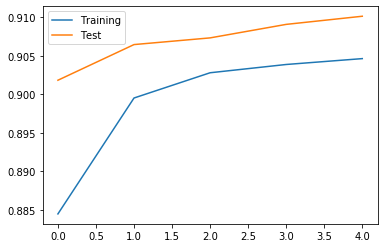

In [382]:
plt.plot(cnn_history.history["accuracy"], label="Training")
plt.plot(cnn_history.history["val_accuracy"], label="Test")
plt.legend()
plt.show()

## 3.3 ROC curve

In [383]:
lstm_result = model_lstm.predict(x_test)
cnn_result = model_cnn.predict(x_test_cnn)

In [387]:
lstm_result.shape,cnn_result.shape,y_test.shape

((19487, 15), (19487, 15), (19487, 15))

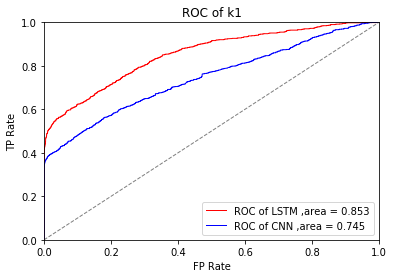

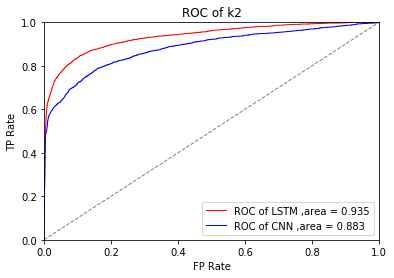

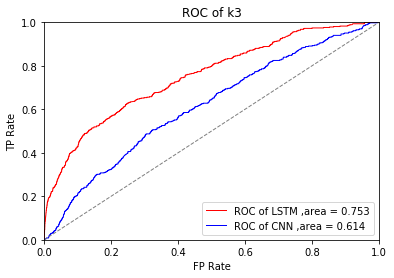

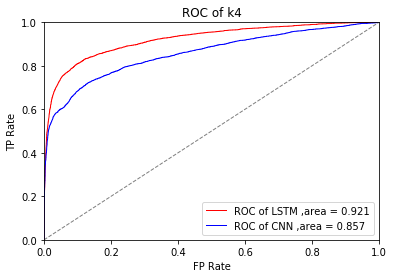

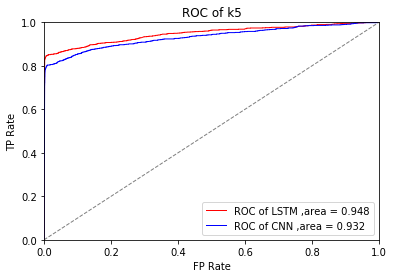

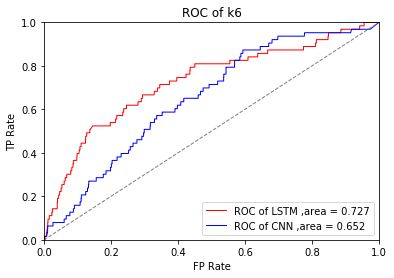

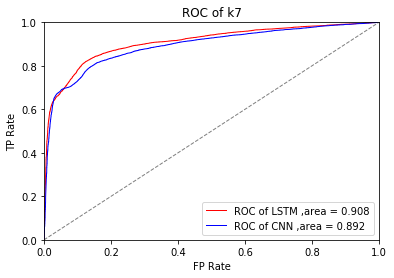

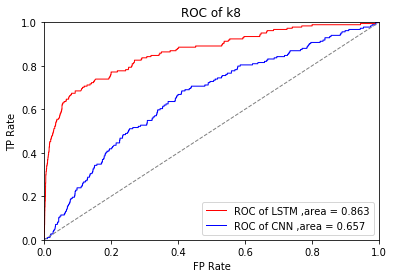

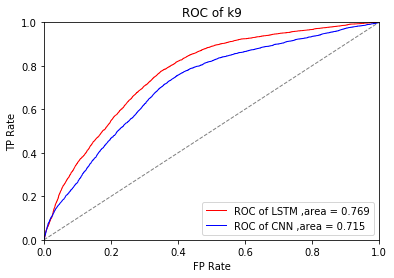

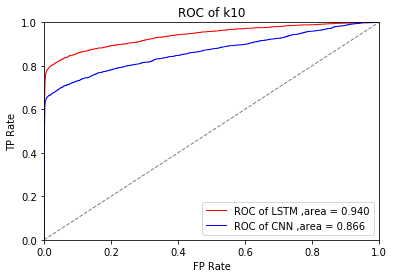

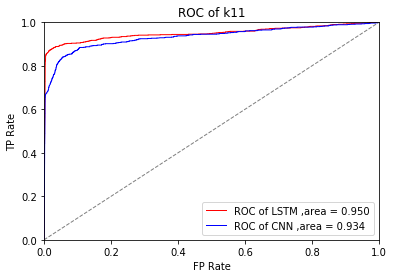

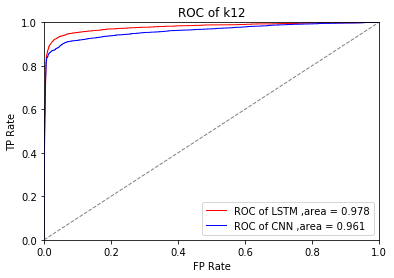

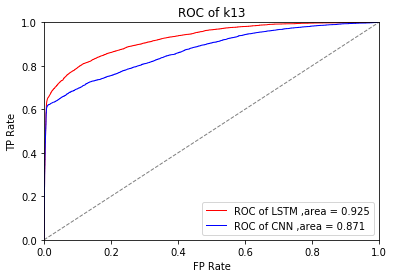

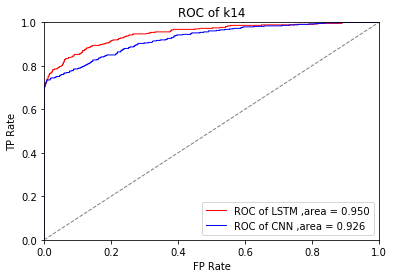

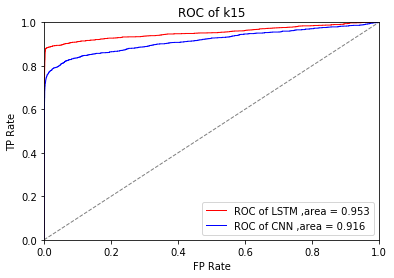

In [396]:
for i in range(15):
    gt = y_test[:,i]>0
    lstm_part = lstm_result[:,i]
    cnn_part = cnn_result[:,i]
    
    fpr_lstm,tpr_lstm,threshold_lstm = roc_curve(gt,lstm_part)
    fpr_cnn,tpr_cnn,threshold_cnn = roc_curve(gt,cnn_part)
    roc_auc_lstm = auc(fpr_lstm,tpr_lstm)
    roc_auc_cnn = auc(fpr_cnn,tpr_cnn)
    
    plt.figure()
    lw = 1
    plt.plot(fpr_lstm, tpr_lstm, 
             color='red',
             lw=lw, 
             label='ROC of LSTM ,area = %0.3f' % roc_auc_lstm)
    plt.plot(fpr_cnn, tpr_cnn, 
             color='blue',
             lw=lw, 
             label='ROC of CNN ,area = %0.3f' % roc_auc_cnn)
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim((0.0, 1.0))
    plt.ylim((0.0, 1.0))
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC of k%s' % str(i+1))
    plt.legend(loc="lower right")
    plt.show()
    